In [3]:
import time
import logging
import sys
import gzip

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

import scipy.stats as stats
from scipy.signal import savgol_filter

from collections import Counter

from scipy import stats
def r(x, y):
    return stats.pearsonr(x, y)[0]

%matplotlib inline

pd.set_option('display.max_colwidth', None)

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 5

In [4]:
#load in preprocessed dfs
samples = ['data_2021-08-27/ky08', 'data_2021-08-27/ky10', 'data_2021-08-27/ky06', 'data_2021-11-10/ky04']
dfs = []

for i, x in enumerate(samples):
    df = pd.read_csv(x+'/'+x[-4:]+'_info.new.clean.gtf')
    print(i)
    dfs.append(df)

0
1
2
3


In [5]:
#clean data

keepme = ['protein_coding', '.']
clean_dfs = []

for df in dfs:
    print(len(df))
    
    reads_to_remove = df[~df['gene_type'].isin(keepme)]['read_id']
    cdf = df[~df.read_id.isin(reads_to_remove)]
    cdf = cdf.drop_duplicates('read_id')
    
    clean_dfs.append(cdf)

6888297
27990357
10827255
14633074


In [97]:
#clean data - run to drop duplicates

keepme = ['protein_coding', '.']
clean_dfs = []

for df in dfs:
    print(len(df))
    
    reads_to_remove = df[~df['gene_type'].isin(keepme)]['read_id']
    cdf = df[~df.read_id.isin(reads_to_remove)]
    cdf = cdf.drop_duplicates('read_id')
    
    print(len(cdf))
          
    cdf = cdf.drop_duplicates(['5prime', '3prime'])
    
    print(len(cdf))
    print()
          
    clean_dfs.append(cdf)

6888297
3690214
606113

27990357
15719468
5936019

10827255
6274283
587766

14633074
8538021
1485233



In [6]:
#load in hotspots
samples = ['data_2021-08-27/ky08', 'data_2021-08-27/ky10', 'data_2021-08-27/ky17', 'data_2021-08-27/ky18']
lorax_sigs = []

for i, x in enumerate(samples):
    df = pd.read_csv(x+'/hotspots.new.clean.gtf')
    print(i)
    lorax_sigs.append(df)

0
1
2
3


In [ ]:
#plot 5' and 3' of lorax around netseq pauses

In [7]:
ws = []
ls = []

for j in [0, 1]:
    for ppp in ['5prime', '3prime']:
        centerprime = '3prime'
        compareprime = ppp

        searchsize = 100
        binsize = 1
        windowsize = int(searchsize/binsize)

        windows = []
        lorax_len = []

        lorax_sig = lorax_sigs[2] #wt pauses
        lorax_sig = lorax_sig[lorax_sig.gene_type == 'protein_coding']
        lorax_sig = lorax_sig[0:10000]

        df = dfs[j]
        
        if 'count' not in df:
            df['count'] = 1

        print(len(lorax_sig))

        chrms = lorax_sig.chr_1.unique()

        for chrom in chrms:
            #print(chrom)

            genesc = lorax_sig[(lorax_sig.chr_1 == chrom)].sort_values(centerprime)
            dfc = df[(df.chr_1 == chrom)].sort_values(compareprime)

            for gene_strand, t, comp_len in zip(genesc.read_strand_1, genesc[centerprime], genesc.comp_len):
                lowerb = t - searchsize
                upperb = t + searchsize

                nets = dfc[compareprime]
                nets_e = dfc[compareprime] + 1
                nets_strand = dfc['read_strand_1']
                counts = dfc['count']

                start = np.searchsorted(nets, lowerb)
                end = np.searchsorted(nets_e, upperb)

                window = [0] * searchsize*2

                for net, net_e, net_strand, count in zip(nets[start:end], nets_e[start:end], nets_strand[start:end], counts[start:end]):
                    if net_strand == gene_strand:
                        if (lowerb < net) and (net_e < upperb):
                            for k in range(net-lowerb, net_e-lowerb):

                                if net_strand == '-':
                                    k = searchsize*2 - k
                                window[k] += count

                window = stats.zscore(window)
                windows.append(window)
                lorax_len.append(comp_len)

        w = np.array(windows)
        ws.append(w)

        l = np.array(lorax_len)
        ls.append(l)

10000
10000
10000
10000


In [11]:
bs = []

for i, (w, l) in enumerate(zip(ws, ls)): 
    bs.append(np.nanmean(w, axis=0))

In [12]:
pdf = pd.DataFrame(bs).T
pdf.columns = ['wt 5', 'wt 3', 'ko 5', 'ko 3']
pdf['xa'] = list(range(-windowsize, windowsize))
pdf = pdf.melt('xa')

pdf['strain'] = pdf.variable.str.split().str[0]
pdf['end'] = pdf.variable.str.split().str[1]

plt.figure(figsize = (2, 1.5))

ax = sns.lineplot(x='xa', y='value', hue='strain', style='end', data=pdf, lw=.5)
ax.set_xlim(-searchsize+1, searchsize-1)
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#plt.savefig('svg/aroundpause.svg', format="svg", dpi=1000)
plt.show()

MemoryError: Unable to allocate 596. GiB for an array with shape (40000, 10000, 200) and data type float64

In [ ]:
bs = []

for i, (w, l) in enumerate(zip(ws, ls)): 
    bs.append(np.nanmean(w, axis=0))

In [ ]:
pdf = pd.DataFrame(bs).T
pdf.columns = ['wt 5', 'wt 3', 'ko 5', 'ko 3']
pdf['xa'] = list(range(-windowsize, windowsize))
pdf = pdf.melt('xa')

pdf['strain'] = pdf.variable.str.split().str[0]
pdf['end'] = pdf.variable.str.split().str[1]

plt.figure(figsize = (2, 1.5))

ax = sns.lineplot(x='xa', y='value', hue='strain', style='end', data=pdf, lw=.5)
ax.set_xlim(-searchsize+1, searchsize-1)
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

#plt.savefig('svg/aroundpause.svg', format="svg", dpi=1000)
plt.show()

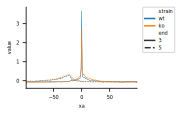

In [100]:
pdf = pd.DataFrame(bs).T
pdf.columns = ['wt 5', 'wt 3', 'ko 5', 'ko 3']
pdf['xa'] = list(range(-windowsize, windowsize))
pdf = pdf.melt('xa')

pdf['strain'] = pdf.variable.str.split().str[0]
pdf['end'] = pdf.variable.str.split().str[1]

plt.figure(figsize = (2, 1.5))

ax = sns.lineplot(x='xa', y='value', hue='strain', style='end', data=pdf.sort_values('end'), lw=.5)
ax.set_xlim(-searchsize+1, searchsize-1)
sns.despine()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.savefig('svg/aroundpause.svg', format="svg", dpi=1000)
plt.show()

In [ ]:
#find amount of backtracking at each pause

In [36]:
filts = []

for j in [2, 3]:

    searchsize = 50

    windows = []
    v = []
    _chr = []
    _3prime = []
    _strand = []

    lorax_sig = lorax_sigs[2] #pauses
    lorax_sig = lorax_sig[lorax_sig.gene_type == 'protein_coding']
    lorax_sig = lorax_sig[0:100000]
    
    df = dfs[j]
    
    if 'count' not in df:
        df['count'] = 1

    print(len(lorax_sig))

    chrms = lorax_sig.chr_1.unique()

    for chrom in chrms:
        #print(chrom)

        genesc = lorax_sig[(lorax_sig.chr_1 == chrom)].sort_values('3prime')
        dfc = df[(df.chr_1 == chrom)].sort_values('3prime')

        for gene_strand, t, val in zip(genesc.read_strand_1, genesc['3prime'], genesc.val):
            lowerb = t - searchsize
            upperb = t + searchsize

            nets = dfc['3prime']
            nets_e = dfc['3prime'] + 1
            nets_strand = dfc['read_strand_1']
            counts = dfc['count']

            start = np.searchsorted(nets, lowerb)
            end = np.searchsorted(nets_e, upperb)

            window=0

            for net, net_e, net_strand, count in zip(nets[start:end], nets_e[start:end], nets_strand[start:end], counts[start:end]):
                if net_strand == gene_strand:
                    if (lowerb < net) and (net_e < upperb):
                        for k in range(net-lowerb, net_e-lowerb):
                            window+=count

            windows.append(window)
            v.append(val)
            _chr.append(chrom)
            _3prime.append(t)
            _strand.append(gene_strand)

    temp = pd.DataFrame(zip(_chr, _3prime, _strand, windows), columns=['chr_1', '3prime', 'read_strand_1', 'window'])
    filt = lorax_sig.merge(temp, on=['chr_1', '3prime', 'read_strand_1']).sort_values('window', ascending=False)
    
    filts.append(filt)

100000
100000


In [37]:
w_norms = []

for i, filt in enumerate(filts):
    
    w = (filt.window) / filt.val
    w_norms.append(w)

WT v.s. KO: t-test independent samples, P_val=3.195e-15 stat=-7.884e+00


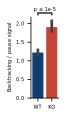

In [38]:
plt.figure(figsize = (.5, 1.5))

pdf = pd.DataFrame(zip(w_norms[0], w_norms[1]), columns=['WT', 'KO'])

#pdf = pdf[pdf.wt < 1]

ax = sns.barplot(data=pdf.melt(), x='variable', y='value', palette = ['#003F80', '#DC3220'])
sns.despine()

ax.set_xlabel('')
ax.set_ylabel('Backtracking / pause signal')

from statannot import add_stat_annotation
box_pairs = [(('WT', 'KO')),
            ]
test_results = add_stat_annotation(ax, data=pdf.melt(), x='variable', y='value',
                                   box_pairs=box_pairs,
                                   test='t-test_ind', text_format='simple', comparisons_correction=None,
                                   loc='outside', verbose=2)
    

plt.savefig('svg/backtrack_pause.svg', format="svg", dpi=1000)

0.31727


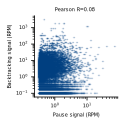

0.53962


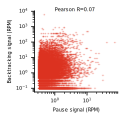

In [41]:
colors = ['#003F80', '#DC3220']

from scipy import stats

for i, filt in enumerate(filts):
    #filt = filt[filt.window > 0]
    s = filt.val * 1E6 / 33457091 #len(wt netseq df)
    
    w = (filt.window * 1E6) / len(dfs[i+2])

    plt.figure(figsize = (1.5, 1.5))
    
    print(len(w[w > 0]) / len(w))

    ax = sns.scatterplot(x=s+1E-1, y=w+1E-1, s=2, rasterized=True, linewidth=0, color=colors[i], alpha=.5)
    #ax = sns.scatterplot(x=s+1E-2, y=w+1E-2, s=2, rasterized=True, linewidth=0, c=kernels)
    sns.despine()
    
    plt.text(1, 1E4, 'Pearson R={:.2f}'.format(r(s, w)))
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    
    ax.set_xlabel('Pause signal (RPM)')
    ax.set_ylabel('Backtracking signal (RPM)')
    
    #ax.axhline(1E-2, color='black', ls=':')
    
    plt.savefig('svg/'+str(i)+'_scatter.svg', format="svg", dpi=1000)
    plt.show()


In [42]:
#load in footprints

foots = []

for n in ['ky03', 'ky04', 'ky05', 'ky06']:
    pos = pd.read_csv('../2022-09-13_TNseq_footprinting/data/'+n+'/'+n+'.plus.bedgraph', sep='\t', names=['chr_1', '5prime', '3prime', 'count'])
    neg = pd.read_csv('../2022-09-13_TNseq_footprinting/data/'+n+'/'+n+'.minus.bedgraph', sep='\t', names=['chr_1', '5prime', '3prime', 'count'])
    pos['read_strand_1'] = '+'
    neg['read_strand_1'] = '-'

    foots.append(pd.concat([pos, neg]))
    print('loaded')

loaded
loaded
loaded
loaded


In [ ]:
#find footprints around strong pauses and pauses with strong backtracking

In [69]:
ws = []
ls = []

for j in [0, 1]:
    for k in [filts[j].sort_values('val', ascending=False).head(1000), filts[j].sort_values('window', ascending=False).head(1000)]:
        
        centerprime = '3prime'
        compareprime = '3prime'

        searchsize = 50
        binsize = 1
        windowsize = int(searchsize/binsize)

        windows = []
        lorax_len = []

        lorax_sig = k
        lorax_sig = lorax_sig[lorax_sig.gene_type == 'protein_coding']

        df = foots[j]

        if 'count' not in df:
            df['count'] = 1

        print(len(lorax_sig))

        chrms = lorax_sig.chr_1.unique()

        for chrom in chrms:
            #print(chrom)

            genesc = lorax_sig[(lorax_sig.chr_1 == chrom)].sort_values(centerprime)
            dfc = df[(df.chr_1 == chrom)].sort_values(compareprime)

            for gene_strand, t, comp_len in zip(genesc.read_strand_1, genesc[centerprime], genesc.comp_len):
                lowerb = t - searchsize
                upperb = t + searchsize

                nets = dfc[compareprime]
                nets_e = dfc[compareprime] + 1
                nets_strand = dfc['read_strand_1']
                counts = dfc['count']

                start = np.searchsorted(nets, lowerb)
                end = np.searchsorted(nets_e, upperb)

                window = [0] * searchsize*2

                for net, net_e, net_strand, count in zip(nets[start:end], nets_e[start:end], nets_strand[start:end], counts[start:end]):
                    if net_strand == gene_strand:
                        if (lowerb < net) and (net_e < upperb):
                            for k in range(net-lowerb, net_e-lowerb):

                                if net_strand == '-':
                                    k = searchsize*2 - k
                                window[k] += count
                                
                window = stats.zscore(window)
                windows.append(window)
                lorax_len.append(comp_len)

        w = np.array(windows)
        ws.append(w)

        l = np.array(lorax_len)
        ls.append(l)

1000
1000
1000
1000


IndexError: list index out of range

In [46]:
bs = []

for i, (w, l) in enumerate(zip(ws, ls)):
    bs.append(np.nanmean(w, axis=0))

In [ ]:
pdf = pd.DataFrame(bs).T
pdf.columns = ['WT strong pauses', 'WT backtracked pauses', 'KO strong pauses', 'KO backtracked pauses']
pdf['xa'] = list(range(-windowsize, windowsize))
pdf = pdf.melt('xa')

plt.figure(figsize = (1.5, 1.5))

ax = sns.lineplot(x='xa', y='value',hue='variable', data=pdf, lw=.5)
ax.set_xlim(-50, 50)
sns.despine()

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.savefig('svg/footaroundpause.svg', format="svg", dpi=1000)
plt.show()

In [ ]:
pdf = pd.DataFrame(bs).T
pdf.columns = ['WT strong pauses', 'WT backtracked pauses', 'KO strong pauses', 'KO backtracked pauses']
pdf['xa'] = list(range(-windowsize, windowsize))
pdf = pdf.melt('xa')

plt.figure(figsize = (1.5, 1.5))

ax = sns.lineplot(x='xa', y='value',hue='variable', data=pdf, lw=.5)
ax.set_xlim(-50, 50)
sns.despine()

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.savefig('svg/footaroundpause2.svg', format="svg", dpi=1000)
plt.show()

In [ ]:
#look for footprints filtering on backtracking distance

In [80]:
ws = []
ls = []

#for j in [0, 1, 2]:
for j in [0, 1]:

    centerprime = '3prime'
    compareprime = '3prime'

    searchsize = 50
    binsize = 1
    windowsize = int(searchsize/binsize)

    windows = []
    lorax_len = []

    lorax_sig = lorax_sigs[1] #really cool sanity check - try subsetting wt netseq pauses by length - it doesn't change footprint density!
    lorax_sig = lorax_sig[lorax_sig.gene_type == 'protein_coding']
    if j == 0:
        lorax_sig = lorax_sig[lorax_sig.comp_len <= 30]
    if j == 1:
        lorax_sig = lorax_sig[lorax_sig.comp_len > 30]
    if j == 2:
        lorax_sig = lorax_sigs[2] #compare to wt netseq pauses
        lorax_sig = lorax_sig[lorax_sig.gene_type == 'protein_coding']
    lorax_sig = lorax_sig[0:10000]

    df = foots[3]

    if 'count' not in df:
        df['count'] = 1

    print(len(lorax_sig))

    chrms = lorax_sig.chr_1.unique()

    for chrom in chrms:
        #print(chrom)

        genesc = lorax_sig[(lorax_sig.chr_1 == chrom)].sort_values(centerprime)
        dfc = df[(df.chr_1 == chrom)].sort_values(compareprime)

        for gene_strand, t, comp_len in zip(genesc.read_strand_1, genesc[centerprime], genesc.comp_len):
            lowerb = t - searchsize
            upperb = t + searchsize

            nets = dfc[compareprime]
            nets_e = dfc[compareprime] + 1
            nets_strand = dfc['read_strand_1']
            counts = dfc['count']

            start = np.searchsorted(nets, lowerb)
            end = np.searchsorted(nets_e, upperb)

            window = [0] * searchsize*2

            for net, net_e, net_strand, count in zip(nets[start:end], nets_e[start:end], nets_strand[start:end], counts[start:end]):
                if net_strand == gene_strand:
                    if (lowerb < net) and (net_e < upperb):
                        for k in range(net-lowerb, net_e-lowerb):

                            if net_strand == '-':
                                k = searchsize*2 - k
                            window[k] += count

            #if sum(window) > 0:
            window = stats.zscore(window)
            windows.append(window)
            lorax_len.append(comp_len)

    w = np.array(windows)
    ws.append(w)

    l = np.array(lorax_len)
    ls.append(l)

10000
10000


In [81]:
bs = []

for i, (w, l) in enumerate(zip(ws, ls)):
    bs.append(np.nanmean(w, axis=0))

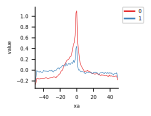

In [79]:
pdf = pd.DataFrame(bs).T
#pdf.columns = ['WT strong pauses', 'WT backtracked pauses', 'KO strong pauses', 'KO backtracked pauses']
pdf['xa'] = list(range(-windowsize, windowsize))
pdf = pdf.melt('xa')

plt.figure(figsize = (1.5, 1.5))

ax = sns.lineplot(x='xa', y='value',hue='variable', data=pdf, lw=.5, palette='Set1')
ax.set_xlim(-50, 50)
sns.despine()

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.savefig('svg/foot_around_len30.svg', format="svg", dpi=1000)

plt.show()

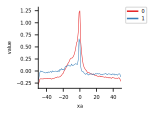

In [82]:
pdf = pd.DataFrame(bs).T
#pdf.columns = ['WT strong pauses', 'WT backtracked pauses', 'KO strong pauses', 'KO backtracked pauses']
pdf['xa'] = list(range(-windowsize, windowsize))
pdf = pdf.melt('xa')

plt.figure(figsize = (1.5, 1.5))

ax = sns.lineplot(x='xa', y='value',hue='variable', data=pdf, lw=.5, palette='Set1')
ax.set_xlim(-50, 50)
sns.despine()

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.savefig('svg/foot_around_len30-2.svg', format="svg", dpi=1000)

plt.show()